In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score, explained_variance_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# Set random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Data Loading and Pre-processing
df = pd.read_csv('/content/drive/My Drive/hydropowerdata/Hydropower_Consumption.csv')
df = df.drop(columns=["Country"])

# Separate features and target
X = df.drop(columns=["2019"])
y = df["2019"]

# Normalize features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X = pd.DataFrame(scaler_X.fit_transform(X), columns=[str(year) for year in range(2000, 2019)])

# Normalize target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Reshape input data for CNN [samples, timesteps, features]
X_train = np.expand_dims(X_train.values, axis=2)
X_test = np.expand_dims(X_test.values, axis=2)



In [5]:
# CNN Model Definition
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Model Training
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stopping], verbose=1)

# Model Prediction
y_pred = model.predict(X_test)


Epoch 1/100
6/6 [==============================] - 2s 75ms/step - loss: 9.9615e-04 - val_loss: 0.0115
Epoch 2/100
6/6 [==============================] - 0s 15ms/step - loss: 2.5272e-04 - val_loss: 0.0121
Epoch 3/100
6/6 [==============================] - 0s 17ms/step - loss: 1.4570e-04 - val_loss: 0.0206
Epoch 4/100
6/6 [==============================] - 0s 15ms/step - loss: 2.0533e-04 - val_loss: 0.0215
Epoch 5/100
6/6 [==============================] - 0s 16ms/step - loss: 1.6352e-04 - val_loss: 0.0193
Epoch 6/100
6/6 [==============================] - 0s 18ms/step - loss: 1.3864e-04 - val_loss: 0.0164
Epoch 7/100
6/6 [==============================] - 0s 14ms/step - loss: 1.4587e-04 - val_loss: 0.0188
Epoch 8/100
6/6 [==============================] - 0s 18ms/step - loss: 1.1578e-04 - val_loss: 0.0179
Epoch 9/100
6/6 [==============================] - 0s 20ms/step - loss: 1.1582e-04 - val_loss: 0.0183
Epoch 10/100
6/6 [==============================] - 0s 18ms/step - loss: 1.1402e-0

In [9]:
y_test_rescaled = scaler_y.inverse_transform(y_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)



In [10]:
# Performance Metrics
r2_valid = r2_score(y_test_rescaled, y_pred_rescaled)
mae_valid = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
evs_valid = explained_variance_score(y_test_rescaled, y_pred_rescaled)
rmse_valid = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
rmsle_valid = np.sqrt(mean_squared_log_error(y_test_rescaled, y_pred_rescaled))

print('CNN Performance:')
print(f'R2 Score: {r2_valid}')
print(f'Explained Variance Score: {evs_valid}')
print(f'Mean Absolute Error: {mae_valid}')
print(f'Root Mean Squared Error: {rmse_valid}')
print(f'Root Mean Squared Log Error: {rmsle_valid}')


CNN Performance:
R2 Score: 0.704332665941295
Explained Variance Score: 0.722399520088504
Mean Absolute Error: 23086.215597401493
Root Mean Squared Error: 77492.09562264706
Root Mean Squared Log Error: 2.6495093034842623


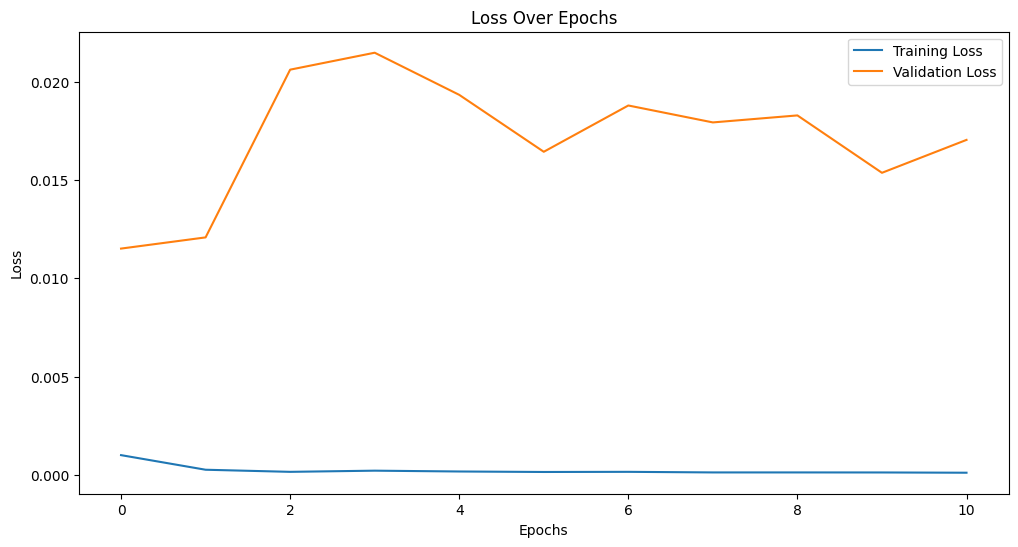

In [11]:
# Plotting Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
# Displaying Predictions
data_prediction = pd.DataFrame(list(zip(y_test_rescaled, y_pred_rescaled)), columns=['Test', 'Prediction'])
data_prediction.head(10)




,Test,Prediction
0,[51541.99999999999],[53119.01]
1,[5544.0],[3357.3215]
2,[16993.0],[11260.508]
3,[35605.0],[31795.793]
4,[20853.0],[22580.61]
5,[40732.0],[51024.082]
6,[632538.0],[725659.25]
7,[676926.0],[890688.06]
8,[874.0],[9568.227]
9,[4005.0],[3987.4568]


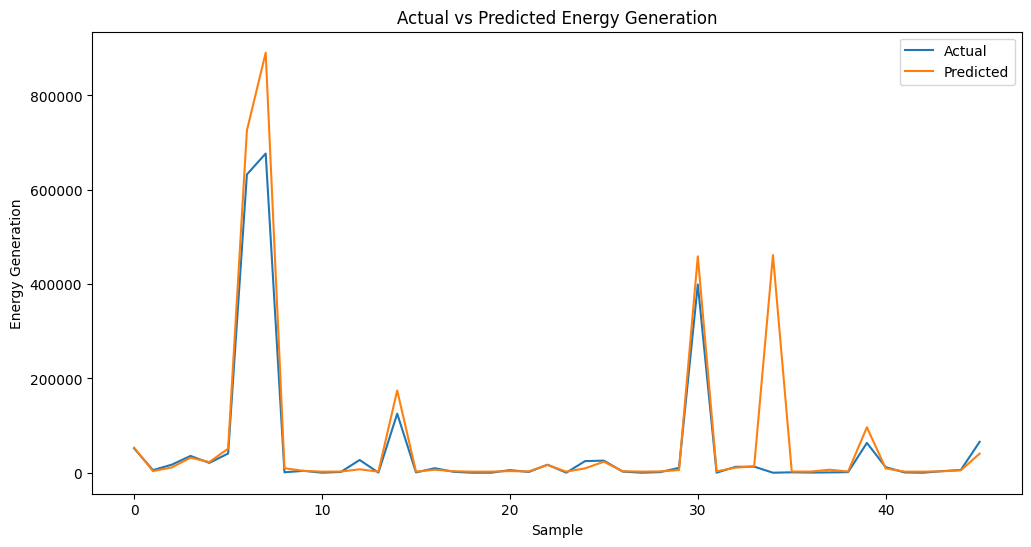

In [14]:
# Plotting Predictions vs Test Values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.title('Actual vs Predicted Energy Generation')
plt.xlabel('Sample')
plt.ylabel('Energy Generation')
plt.legend()
plt.show()